In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import random

In [44]:
file_path = "corrected_dataset.csv"
data = pd.read_csv(file_path)
data = data.select_dtypes(include=[np.number])  # Keep only numerical columns
data.dropna(inplace=True)  # Drop rows with missing values
# categorical_columns = data.select_dtypes(include=['object']).columns

# # Apply one-hot encoding to categorical columns
# data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
# Normalize numerical data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

In [45]:
class OptimizationData:
    def __init__(self, n_clusters, n_agents, max_iter, data):
        self.n_clusters = n_clusters
        self.n_agents = n_agents
        self.max_iter = max_iter
        self.data = data

In [46]:

# Define Gravitational Search Algorithm (GSA) for clustering
class GSAClustering:
    def __init__(self, data, n_clusters, n_agents, max_iter, G0=100, alpha=20):
        self.data = data
        self.n_clusters = n_clusters
        self.n_agents = n_agents
        self.max_iter = max_iter
        self.G0 = G0
        self.alpha = alpha
        self.agents = [self.initialize_agent() for _ in range(n_agents)]
        self.best_agent = None
        self.best_fitness = -1

    def initialize_agent(self):
        """Randomly initialize agent positions (centroids)."""
        return np.array([self.data[random.randint(0, len(self.data) - 1)] for _ in range(self.n_clusters)])

    def fitness(self, agent):
        """Calculate fitness of an agent using the Silhouette Coefficient."""
        labels = self.assign_clusters(agent)
        if len(set(labels)) < 2:  # Silhouette requires at least 2 clusters
            return -1
        # print("current fitness : ",silhouette_score(self.data, labels))
        return silhouette_score(self.data, labels)

    def assign_clusters(self, centroids):
        """Assign each data point to the nearest centroid."""
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def update_agents(self, G):
        """Update agent positions based on gravitational forces."""
        masses = np.array([self.fitness(agent) for agent in self.agents])
        masses = (masses - masses.min()) / (masses.max() - masses.min() + 1e-9)  # Normalize masses
        total_mass = masses.sum()

        # Compute forces
        new_agents = []
        for i, agent in enumerate(self.agents):
            force = np.zeros_like(agent)
            for j, other_agent in enumerate(self.agents):
                if i != j:
                    distance = np.linalg.norm(agent - other_agent) + 1e-9
                    force += G * (masses[j] * masses[i]) / distance * (other_agent - agent)
            acceleration = force / (masses[i] + 1e-9)
            new_agents.append(agent + np.random.random() * acceleration)  # Update position
        self.agents = new_agents

    def optimize(self):
        """Run the optimization process."""
        performance_over_time=[]
        for iteration in range(self.max_iter):
            G = self.G0 * np.exp(-self.alpha * iteration / self.max_iter)
            self.update_agents(G)
            for agent in self.agents:
                fitness = self.fitness(agent)
                if fitness > self.best_fitness:
                    self.best_fitness = fitness
                    self.best_agent = agent
            performance_over_time.append(self.best_fitness)
            print(f"Iteration {iteration + 1}/{self.max_iter}, Best Fitness: {self.best_fitness}")
        return self.best_agent, self.best_fitness,performance_over_time

In [47]:
class HybridGSA_SA:
    def __init__(self, data, n_agents, n_iterations, temp, cooling_rate):
        """
        Initialize the Hybrid GSA + SA.
        :param data: Input dataset.
        :param n_agents: Number of agents (solutions).
        :param n_iterations: Maximum number of iterations.
        :param temp: Initial temperature for SA.
        :param cooling_rate: Cooling rate for SA.
        """
        self.data = data
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.temp = temp
        self.cooling_rate = cooling_rate

    def initialize_agents(self, n_clusters):
        """
        Initialize agent positions randomly.
        :param n_clusters: Number of clusters.
        :return: Initialized agent positions.
        """
        return np.random.rand(self.n_agents, n_clusters, self.data.shape[1])

    def calculate_fitness(self, agents):
        """
        Calculate the fitness (Silhouette Score) for each agent.
        :param agents: Agent positions.
        :return: Array of fitness scores.
        """
        fitness = []
        for agent in agents:
            labels = self.assign_clusters(agent)
            if len(set(labels)) > 1:  # Avoid silhouette calculation if only one cluster
                score = silhouette_score(self.data, labels)
            else:
                score = -1  # Invalid clustering
            fitness.append(score)
        return np.array(fitness)

    def assign_clusters(self, centroids):
        """
        Assign data points to the nearest centroid.
        :param centroids: Centroid positions.
        :return: Cluster labels.
        """
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def update_positions(self, agents, masses, iteration):
        """
        Update the positions of agents based on gravitational forces.
        :param agents: Current agent positions.
        :param masses: Masses of agents.
        :param iteration: Current iteration number.
        :return: Updated agent positions.
        """
        G = 1 / (1 + iteration)  # Gravitational constant decreases over time

        new_agents = np.copy(agents)
        for i, agent in enumerate(agents):
            force = np.zeros(agent.shape)
            for j, other_agent in enumerate(agents):
                if i != j:
                    r = np.linalg.norm(agent - other_agent)
                    if r > 0:
                        force += G * masses[j] * (other_agent - agent) / r
            new_agents[i] += np.random.rand() * force  # Update position
        return new_agents

    def simulated_annealing(self, agent, current_fitness):
        """
        Perform local optimization using Simulated Annealing.
        :param agent: Current agent (centroid positions).
        :param current_fitness: Fitness of the current agent.
        :return: Optimized agent.
        """
        temp = self.temp
        best_agent = agent
        best_fitness = current_fitness
        counter=10
        while (temp > 1) & (counter>0) :
            # Generate a neighboring solution
            new_agent = agent + np.random.normal(0, 0.1, size=agent.shape)
            labels = self.assign_clusters(new_agent)

            if len(set(labels)) > 1:
                new_fitness = silhouette_score(self.data, labels)
            else:
                new_fitness = -1  # Invalid clustering

            # Accept the new solution with Metropolis criterion
            if new_fitness > best_fitness or np.exp((new_fitness - best_fitness) / temp) > np.random.rand():
                best_agent = new_agent
                best_fitness = new_fitness

            # Cool down the temperature
            temp *= self.cooling_rate
            counter-=1
        return best_agent

    def fit(self, n_clusters):
        """
        Run the Hybrid GSA + SA to find optimal clusters.
        :param n_clusters: Number of clusters.
        :return: Best centroids, best fitness, performance over iterations.
        """
        agents = self.initialize_agents(n_clusters)
        fitness = self.calculate_fitness(agents)

        best_agent = agents[np.argmax(fitness)]
        best_fitness = np.max(fitness)
        performance_over_time = []

        for iteration in range(self.n_iterations):
            # Calculate masses based on fitness
            min_fitness = np.min(fitness)
            max_fitness = np.max(fitness)
            masses = (fitness - min_fitness) / (max_fitness - min_fitness + 1e-6)

            # Update agent positions using GSA
            agents = self.update_positions(agents, masses, iteration)

            # Apply Simulated Annealing for local optimization
            for i in range(len(agents)):
                agents[i] = self.simulated_annealing(agents[i], fitness[i])

            # Recalculate fitness
            fitness = self.calculate_fitness(agents)

            # Update global best
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_agent = agents[np.argmax(fitness)]

            # Track performance
            performance_over_time.append(best_fitness)
            print(f"Iteration {iteration + 1}/{self.n_iterations}, Best Fitness: {best_fitness}")

        return best_agent, best_fitness, performance_over_time


In [48]:
class HybridGSA_SA_AgeDiversity:
    def __init__(self, data, n_agents, n_iterations, alpha, age_threshold):
        """
        Initialize the Hybrid GSA + SA algorithm with Age Diversity Monitoring.
        :param data: Input dataset.
        :param n_agents: Number of agents (solutions).
        :param n_iterations: Maximum number of iterations.
        :param alpha: Simulated annealing cooling rate.
        :param age_threshold: Threshold for stagnation age.
        """
        self.data = data
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.age_threshold = age_threshold

    def initialize_agents(self, n_clusters):
        agents = np.random.rand(self.n_agents, n_clusters, self.data.shape[1])
        ages = np.zeros(self.n_agents)  # Initialize ages for all agents
        return agents, ages

    def calculate_fitness(self, agents):
        fitness = []
        for agent in agents:
            labels = self.assign_clusters(agent)
            if len(set(labels)) > 1:  # Avoid silhouette calculation if only one cluster
                score = silhouette_score(self.data, labels)
            else:
                score = -1  # Invalid clustering
            fitness.append(score)
        return np.array(fitness)

    def assign_clusters(self, centroids):
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def update_positions(self, agents, fitness, iteration):
        G = 1 / (1 + iteration)  # Gravitational constant decreases over time
        sorted_indices = np.argsort(fitness)[::-1]
        best_agents = agents[sorted_indices]
        best_fitness = fitness[sorted_indices]

        new_agents = np.copy(agents)
        for i, agent in enumerate(agents):
            force = np.zeros(agent.shape)
            for j, best_agent in enumerate(best_agents):
                if i != j:  # Avoid self-interaction
                    r = np.linalg.norm(agent - best_agent)
                    if r > 0:
                        force += G * (best_fitness[j] - best_fitness[i]) * (best_agent - agent) / r
            new_agents[i] += np.random.rand() * force  # Update position

        return new_agents

    def simulated_annealing(self, agent, best_fitness, temperature):
        new_agent = agent + np.random.normal(0, 0.1, agent.shape)
        labels = self.assign_clusters(new_agent)
        if len(set(labels)) > 1:
            new_fitness = silhouette_score(self.data, labels)
        else:
            new_fitness = -1

        if new_fitness > best_fitness or np.random.rand() < np.exp((new_fitness - best_fitness) / temperature):
            return new_agent, new_fitness
        return agent, best_fitness

    def reinitialize_agent(self, agent):
        return np.random.rand(*agent.shape)

    def fit(self, n_clusters):
        agents, ages = self.initialize_agents(n_clusters)
        fitness = self.calculate_fitness(agents)

        best_agent = agents[np.argmax(fitness)]
        best_fitness = np.max(fitness)

        temperature = 1.0  # Initial temperature for simulated annealing
        performance_over_time = []

        for iteration in range(self.n_iterations):
            # Update agent positions using GSA
            agents = self.update_positions(agents, fitness, iteration)

            # Apply simulated annealing to improve agents
            for i in range(self.n_agents):
                agents[i], fitness[i] = self.simulated_annealing(agents[i], fitness[i], temperature)

                # Monitor stagnation and reinitialize if necessary
                if fitness[i] <= fitness[i]:
                    ages[i] += 1
                else:
                    ages[i] = 0  # Reset age if fitness improves

                if ages[i] > self.age_threshold:
                    agents[i] = self.reinitialize_agent(agents[i])
                    ages[i] = 0  # Reset age after reinitialization

            # Update global best
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_agent = agents[np.argmax(fitness)]

            # Cooling schedule for simulated annealing
            temperature *= self.alpha

            # Track performance
            performance_over_time.append(best_fitness)
            # print(f"Iteration {iteration + 1}/{self.n_iterations}, Best Fitness: {best_fitness}")

        return best_agent, best_fitness, performance_over_time
    

In [49]:
class GSAWithEliteAgents:
    def __init__(self, data, n_agents, n_iterations, elite_fraction):
        """
        Initialize the GSA with Elite Agents.
        :param data: Input dataset.
        :param n_agents: Number of agents (solutions).
        :param n_iterations: Maximum number of iterations.
        :param elite_fraction: Fraction of agents considered as elites.
        """
        self.data = data
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.n_elites = max(1, int(n_agents * elite_fraction))  # At least 1 elite agent

    def initialize_agents(self, n_clusters):
        """
        Initialize agent positions randomly.
        :param n_clusters: Number of clusters.
        :return: Initialized agent positions.
        """
        return np.random.rand(self.n_agents, n_clusters, self.data.shape[1])

    def calculate_fitness(self, agents):
        """
        Calculate the fitness (Silhouette Score) for each agent.
        :param agents: Agent positions.
        :return: Array of fitness scores.
        """
        fitness = []
        for agent in agents:
            labels = self.assign_clusters(agent)
            if len(set(labels)) > 1:  # Avoid silhouette calculation if only one cluster
                score = silhouette_score(self.data, labels)
            else:
                score = -1  # Invalid clustering
            fitness.append(score)
        return np.array(fitness)

    def assign_clusters(self, centroids):
        """
        Assign data points to the nearest centroid.
        :param centroids: Centroid positions.
        :return: Cluster labels.
        """
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def update_positions(self, agents, fitness, iteration):
        """
        Update the positions of agents based on gravitational forces from elites.
        :param agents: Current agent positions.
        :param fitness: Current fitness values of agents.
        :param iteration: Current iteration number.
        :return: Updated agent positions.
        """
        G = 1 / (1 + iteration)  # Gravitational constant decreases over time
        sorted_indices = np.argsort(fitness)[::-1]
        elites = agents[sorted_indices[:self.n_elites]]  # Select elite agents
        best_fitness = fitness[sorted_indices[0]]

        new_agents = np.copy(agents)
        for i, agent in enumerate(agents):
            force = np.zeros(agent.shape)
            for elite in elites:
                r = np.linalg.norm(agent - elite)
                if r > 0:
                    force += G * (best_fitness - fitness[i]) * (elite - agent) / r
            new_agents[i] += np.random.rand() * force  # Update position
        return new_agents

    def fit(self, n_clusters):
        """
        Run the GSA with Elite Agents to find optimal clusters.
        :param n_clusters: Number of clusters.
        :return: Best centroids, best fitness, performance over iterations.
        """
        agents = self.initialize_agents(n_clusters)
        fitness = self.calculate_fitness(agents)

        best_agent = agents[np.argmax(fitness)]
        best_fitness = np.max(fitness)
        performance_over_time = []

        for iteration in range(self.n_iterations):
            # Update agent positions
            agents = self.update_positions(agents, fitness, iteration)

            # Recalculate fitness
            fitness = self.calculate_fitness(agents)

            # Update global best
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_agent = agents[np.argmax(fitness)]

            # Track performance
            performance_over_time.append(best_fitness)
            # print(f"Iteration {iteration + 1}/{self.n_iterations}, Best Fitness: {best_fitness}")

        return best_agent, best_fitness, performance_over_time

In [50]:
class HybridGSA_SA_Elite:
    def __init__(self, data, n_agents, n_iterations, alpha, elite_fraction):
        """
        Initialize the Hybrid GSA + SA with Elite Agents.
        :param data: Input dataset.
        :param n_agents: Number of agents (solutions).
        :param n_iterations: Maximum number of iterations.
        :param alpha: Simulated annealing cooling rate.
        :param elite_fraction: Fraction of agents considered as elites.
        """
        self.data = data
        self.n_agents = n_agents
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.n_elites = max(1, int(n_agents * elite_fraction))  # At least 1 elite agent

    def initialize_agents(self, n_clusters):
        agents = np.random.rand(self.n_agents, n_clusters, self.data.shape[1])
        return agents

    def calculate_fitness(self, agents):
        fitness = []
        for agent in agents:
            labels = self.assign_clusters(agent)
            if len(set(labels)) > 1:  # Avoid silhouette calculation if only one cluster
                score = silhouette_score(self.data, labels)
            else:
                score = -1  # Invalid clustering
            fitness.append(score)
        return np.array(fitness)

    def assign_clusters(self, centroids):
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def update_positions(self, agents, fitness, iteration):
        G = 1 / (1 + iteration)  # Gravitational constant decreases over time
        sorted_indices = np.argsort(fitness)[::-1]
        elites = agents[sorted_indices[:self.n_elites]]  # Select elite agents
        best_agents = agents[sorted_indices]

        new_agents = np.copy(agents)
        for i, agent in enumerate(agents):
            force = np.zeros(agent.shape)
            for elite in elites:
                r = np.linalg.norm(agent - elite)
                if r > 0:
                    force += G * (silhouette_score(self.data, self.assign_clusters(elite)) - fitness[i]) * (elite - agent) / r

            new_agents[i] += np.random.rand() * force  # Update position

        return new_agents

    def simulated_annealing(self, agent, best_fitness, temperature):
        new_agent = agent + np.random.normal(0, 0.1, agent.shape)
        labels = self.assign_clusters(new_agent)
        if len(set(labels)) > 1:
            new_fitness = silhouette_score(self.data, labels)
        else:
            new_fitness = -1

        if new_fitness > best_fitness or np.random.rand() < np.exp((new_fitness - best_fitness) / temperature):
            return new_agent, new_fitness
        return agent, best_fitness

    def fit(self, n_clusters):
        agents = self.initialize_agents(n_clusters)
        fitness = self.calculate_fitness(agents)

        best_agent = agents[np.argmax(fitness)]
        best_fitness = np.max(fitness)

        temperature = 1.0  # Initial temperature for simulated annealing
        performance_over_time = []

        for iteration in range(self.n_iterations):
            # Update agent positions using GSA with elite influence
            agents = self.update_positions(agents, fitness, iteration)

            # Apply simulated annealing to improve agents
            for i in range(self.n_agents):
                agents[i], fitness[i] = self.simulated_annealing(agents[i], fitness[i], temperature)

            # Update global best
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_agent = agents[np.argmax(fitness)]

            # Cooling schedule for simulated annealing
            temperature *= self.alpha

            # Track performance
            performance_over_time.append(best_fitness)
            # print(f"Iteration {iteration + 1}/{self.n_iterations}, Best Fitness: {best_fitness}")

        return best_agent, best_fitness, performance_over_time


In [51]:
class GSAWithDistanceWeightedMasses:
    def __init__(self, data, n_agents, n_iterations):
        """
        Initialize the GSA with Distance-Weighted Masses.
        :param data: Input dataset.
        :param n_agents: Number of agents (solutions).
        :param n_iterations: Maximum number of iterations.
        """
        self.data = data
        self.n_agents = n_agents
        self.n_iterations = n_iterations

    def initialize_agents(self, n_clusters):
        """
        Initialize agent positions randomly.
        :param n_clusters: Number of clusters.
        :return: Initialized agent positions.
        """
        return np.random.rand(self.n_agents, n_clusters, self.data.shape[1])

    def calculate_fitness(self, agents):
        """
        Calculate the fitness (Silhouette Score) for each agent.
        :param agents: Agent positions.
        :return: Array of fitness scores.
        """
        fitness = []
        for agent in agents:
            labels = self.assign_clusters(agent)
            if len(set(labels)) > 1:  # Avoid silhouette calculation if only one cluster
                score = silhouette_score(self.data, labels)
            else:
                score = -1  # Invalid clustering
            fitness.append(score)
        return np.array(fitness)

    def assign_clusters(self, centroids):
        """
        Assign data points to the nearest centroid.
        :param centroids: Centroid positions.
        :return: Cluster labels.
        """
        distances = np.linalg.norm(self.data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    def calculate_distance_weighted_masses(self, agents, fitness):
        """
        Calculate masses weighted by fitness and distance.
        :param agents: Agent positions.
        :param fitness: Fitness values of agents.
        :return: Distance-weighted masses for each agent.
        """
        min_fitness = np.min(fitness)
        max_fitness = np.max(fitness)
        masses = (fitness - min_fitness) / (max_fitness - min_fitness + 1e-6)

        # Calculate pairwise distances between agents (centroids flattened for each agent)
        agents_flat = agents.reshape(self.n_agents, -1)  # Flatten centroids
        distances = np.linalg.norm(agents_flat[:, np.newaxis] - agents_flat, axis=2)
        
        # Avoid division by zero (self-influence)
        np.fill_diagonal(distances, np.inf)
        
        # Calculate distance-weighted masses
        weighted_masses = masses / (distances + 1e-6)  # Add small value to avoid division by zero
        return np.sum(weighted_masses, axis=1)


    def update_positions(self, agents, masses, iteration):
        """
        Update the positions of agents based on gravitational forces.
        :param agents: Current agent positions.
        :param masses: Masses of agents.
        :param iteration: Current iteration number.
        :return: Updated agent positions.
        """
        G = 1 / (1 + iteration)  # Gravitational constant decreases over time

        new_agents = np.copy(agents)
        for i, agent in enumerate(agents):
            force = np.zeros(agent.shape)
            for j, other_agent in enumerate(agents):
                if i != j:
                    r = np.linalg.norm(agent - other_agent)
                    if r > 0:
                        force += G * masses[j] * (other_agent - agent) / r
            new_agents[i] += np.random.rand() * force  # Update position
        return new_agents

    def fit(self, n_clusters):
        """
        Run the GSA with Distance-Weighted Masses to find optimal clusters.
        :param n_clusters: Number of clusters.
        :return: Best centroids, best fitness, performance over iterations.
        """
        agents = self.initialize_agents(n_clusters)
        fitness = self.calculate_fitness(agents)

        best_agent = agents[np.argmax(fitness)]
        best_fitness = np.max(fitness)
        performance_over_time = []

        for iteration in range(self.n_iterations):
            # Calculate distance-weighted masses
            masses = self.calculate_distance_weighted_masses(agents, fitness)

            # Update agent positions
            agents = self.update_positions(agents, masses, iteration)

            # Recalculate fitness
            fitness = self.calculate_fitness(agents)

            # Update global best
            current_best_fitness = np.max(fitness)
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                best_agent = agents[np.argmax(fitness)]

            # Track performance
            performance_over_time.append(best_fitness)
            # print(f"Iteration {iteration + 1}/{self.n_iterations}, Best Fitness: {best_fitness}")

        return best_agent, best_fitness, performance_over_time

c:\Users\Bansa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the

Iteration 1/100, Best Fitness: 0.3183621272589128
Iteration 2/100, Best Fitness: 0.3183621272589128
Iteration 3/100, Best Fitness: 0.3183621272589128
Iteration 4/100, Best Fitness: 0.3183621272589128
Iteration 5/100, Best Fitness: 0.3183621272589128
Iteration 6/100, Best Fitness: 0.3183621272589128
Iteration 7/100, Best Fitness: 0.3183621272589128
Iteration 8/100, Best Fitness: 0.3183621272589128
Iteration 9/100, Best Fitness: 0.3183621272589128
Iteration 10/100, Best Fitness: 0.3183621272589128
Iteration 11/100, Best Fitness: 0.3183621272589128
Iteration 12/100, Best Fitness: 0.3183621272589128
Iteration 13/100, Best Fitness: 0.3183621272589128
Iteration 14/100, Best Fitness: 0.3183621272589128
Iteration 15/100, Best Fitness: 0.3183621272589128
Iteration 16/100, Best Fitness: 0.3183621272589128
Iteration 17/100, Best Fitness: 0.3183621272589128
Iteration 18/100, Best Fitness: 0.3183621272589128
Iteration 19/100, Best Fitness: 0.3183621272589128
Iteration 20/100, Best Fitness: 0.318362

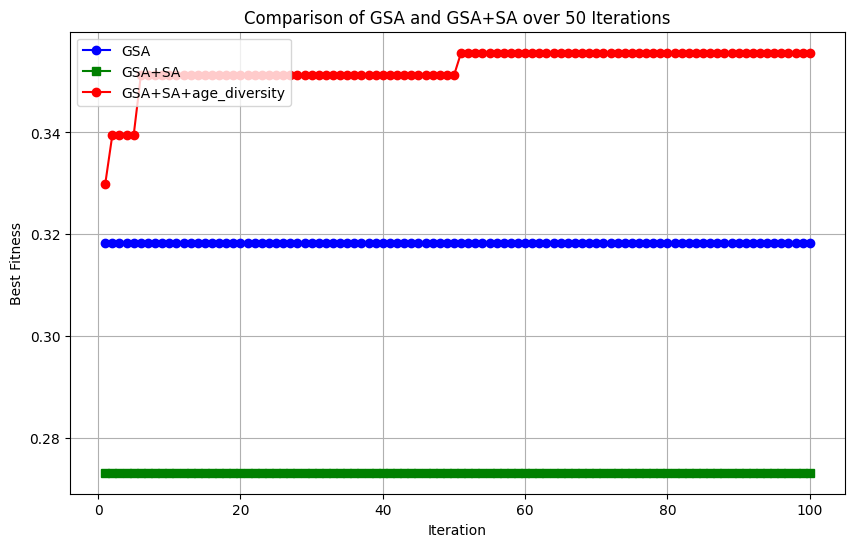


Running K_mean...
Silhouette Score: 0.2898
Cluster Centroids:
[[-3.78085207e-01 -3.21499970e-01 -3.70578679e-01 -2.72598567e-01
  -3.37774591e-01  5.98494557e-02 -7.96913440e-02  6.45428937e-02
  -5.83404343e-01 -6.20754932e-01 -1.11292080e-01  2.88013649e-01
  -2.63587846e-01]
 [ 8.59657337e-01 -4.87722365e-01  1.12155296e+00 -2.72598567e-01
   1.07020675e+00 -5.03199069e-01  7.97706685e-01 -8.46723096e-01
   1.24602661e+00  1.31930043e+00  6.57524768e-01 -6.81641377e-01
   9.46287747e-01]
 [-4.12886160e-01  1.89124798e+00 -1.10177086e+00 -2.25681943e-01
  -1.14278782e+00  6.30711855e-01 -1.37034852e+00  1.51424829e+00
  -6.16064589e-01 -6.03750798e-01 -7.18119529e-01  3.54762432e-01
  -9.05184408e-01]
 [-1.98746146e-01 -2.60501122e-01  2.80272652e-01  3.66839786e+00
   3.83457500e-01  2.75940917e-01  3.72500504e-01 -4.03737321e-01
   1.08251436e-03 -9.76598453e-02 -3.92846867e-01  1.71712470e-01
  -1.64515168e-01]]

Running Hierarchical_method...
Best Fitness (Silhouette Coefficient

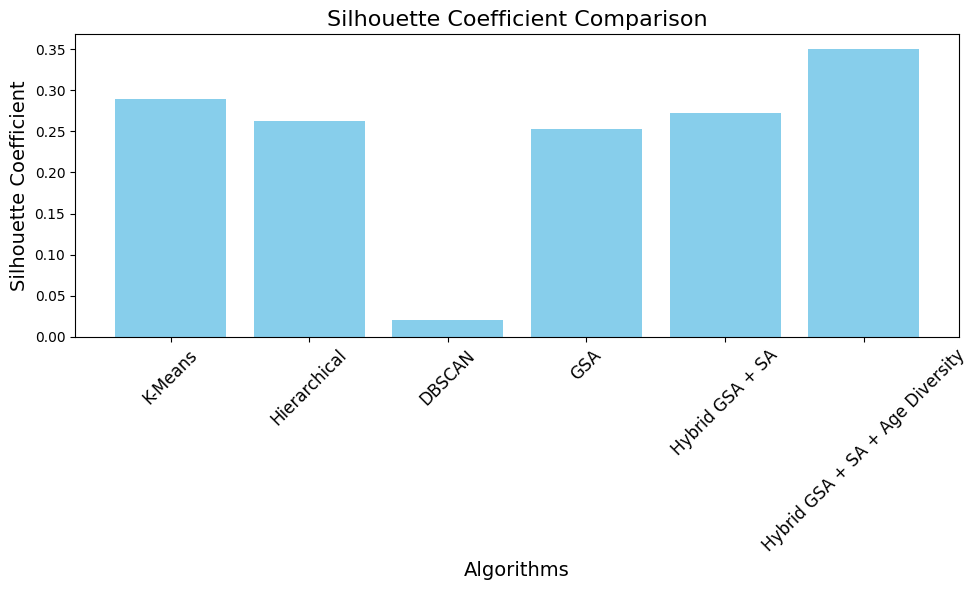

In [52]:

import matplotlib.pyplot as plt
import numpy as np

class OptimizationManager:
    def __init__(self, data, n_clusters=4, n_agents=2, max_iter=100):
        self.data = OptimizationData(n_clusters, n_agents, max_iter, data)

    def run_optimizations(self):
        silhouette_scores = []

    
        # Generate synthetic data for clustering
        n_samples = 300
        n_features = 2
        n_clusters = 4
        
        # Parameters
        n_agents = 2
        max_iterations = 100
        temperature = 100
        cooling_rate = 0.95

        # Run GSA
        gsa = GSAClustering(data=self.data.data, n_clusters=n_clusters, n_agents=n_agents, max_iter=max_iterations)
        _, best_fitness_gsa, gsa_performance = gsa.optimize()

        # Run GSA + SA
        hybrid_gsa_sa = HybridGSA_SA(data=self.data.data, n_agents=n_agents, n_iterations=max_iterations, temp=temperature, cooling_rate=cooling_rate)
        _, best_fitness_hybrid, performance_hybrid = hybrid_gsa_sa.fit(n_clusters=n_clusters)
        alpha = 0.95
        age_threshold = 10
        hybrid_gsa_sa_age = HybridGSA_SA_AgeDiversity(self.data.data, self.data.n_agents, self.data.max_iter, alpha, age_threshold)
        best_centroids, best_fitness, performance_sa_age = hybrid_gsa_sa_age.fit(self.data.n_agents)
        # # For GSA, track performance at each iteration
        # gsa_performance = []
        # for iteration in range(max_iterations):
        #     gsa_performance.append(gsa.best_fitness)

        # Plot the comparison
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_iterations + 1), gsa_performance, label='GSA', marker='o', color='blue')
        plt.plot(range(1, max_iterations + 1), performance_hybrid, label='GSA+SA', marker='s', color='green')
        plt.plot(range(1, max_iterations + 1), performance_sa_age, label='GSA+SA+age_diversity', marker='o', color='red')
        plt.title('Comparison of GSA and GSA+SA over 50 Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Best Fitness')
        plt.legend()
        plt.grid()
        plt.show()

        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        print("\nRunning K_mean...")
        kmeans = KMeans(n_clusters=self.data.n_clusters, random_state=42, n_init=10, max_iter=300)
        labels = kmeans.fit_predict(self.data.data)
        centroids = kmeans.cluster_centers_
        silhouette_avg = silhouette_score(self.data.data, labels)
        silhouette_scores.append(("K-Means", silhouette_avg))
        print(f"Silhouette Score: {silhouette_avg:.4f}")
        print(f"Cluster Centroids:\n{centroids}")

        print("\nRunning Hierarchical_method...")
        linkage_matrix = linkage(self.data.data, method='ward')  # "ward", "single", "complete", "average"
        cluster_labels = fcluster(linkage_matrix, self.data.n_clusters, criterion='maxclust')
        silhouette_avg = silhouette_score(self.data.data, cluster_labels)
        silhouette_scores.append(("Hierarchical", silhouette_avg))
        print(f"Best Fitness (Silhouette Coefficient): {silhouette_avg:.4f}")

        print("\nRunning DBSCAN...")
        epsilon = 1.3 
        min_samples = 3 
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(self.data.data)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        if n_clusters > 1:
            silhouette_avg = silhouette_score(self.data.data, cluster_labels)
        else:
            silhouette_avg = -1
        silhouette_scores.append(("DBSCAN", silhouette_avg))
        print(f"Number of Noise Points: {n_noise}")
        print(f"Silhouette Score: {silhouette_avg:.4f}" if silhouette_avg != -1 else "Silhouette Score not defined for single cluster")

        print("\nRunning Gravitational Search Algorithm...")
        gsa = GSAClustering(self.data.data, n_clusters=self.data.n_clusters, n_agents=self.data.n_agents, max_iter=self.data.max_iter)
        best_centroids, best_fitness,performance = gsa.optimize()
        silhouette_scores.append(("GSA", best_fitness))
        print("Best Fitness (Silhouette Coefficient):", best_fitness)
        print("Cluster Centers:\n", best_centroids)

        print("\nRunning Hybrid GSA + Simulated Annealing...")
        temp = 100
        cooling_rate = 0.95
        hybrid_gsa_sa = HybridGSA_SA(self.data.data, self.data.n_agents, self.data.max_iter, temp, cooling_rate)
        best_centroids, best_fitness, performance = hybrid_gsa_sa.fit(self.data.n_clusters)
        silhouette_scores.append(("Hybrid GSA + SA", best_fitness))
        print("Best Fitness (Silhouette Coefficient):", best_fitness)
        print("Cluster Centers:\n", best_centroids)

        print("\nRunning Hybrid GSA + SA + Age Diversity...")
        alpha = 0.95
        age_threshold = 10
        hybrid_gsa_sa_age = HybridGSA_SA_AgeDiversity(self.data.data, self.data.n_agents, self.data.max_iter, alpha, age_threshold)
        best_centroids, best_fitness, performance = hybrid_gsa_sa_age.fit(self.data.n_agents)
        silhouette_scores.append(("Hybrid GSA + SA + Age Diversity", best_fitness))
        print("Best Fitness (Silhouette Coefficient):", best_fitness)
        print("Cluster Centers:\n", best_centroids)

        # print("\nRunning Hybrid GSA + SA + Elite Agents...")
        # elite_fraction = 0.2
        # hybrid_gsa_sa_elite = HybridGSA_SA_Elite(self.data.data, self.data.n_agents, self.data.max_iter, alpha, elite_fraction)
        # best_centroids, best_fitness, performance = hybrid_gsa_sa_elite.fit(self.data.n_agents)
        # silhouette_scores.append(("Hybrid GSA + SA + Elite Agents", best_fitness))
        # print("Best Fitness (Silhouette Coefficient):", best_fitness)
        # print("Cluster Centers:\n", best_centroids)

        # print("\nRunning GSA with Elite Agents...")
        # gsa_elite = GSAWithEliteAgents(self.data.data, self.data.n_agents, self.data.max_iter, elite_fraction)
        # best_centroids, best_fitness, performance = gsa_elite.fit(self.data.n_agents)
        # silhouette_scores.append(("GSA with Elite Agents", best_fitness))
        # print("Best Fitness (Silhouette Coefficient):", best_fitness)
        # print("Cluster Centers:\n", best_centroids)

        # print("\nRunning GSA with Distance Weighted Masses...")
        # gsa_distance_weighted = GSAWithDistanceWeightedMasses(self.data.data, self.data.n_agents, self.data.max_iter)
        # best_centroids, best_fitness, performance = gsa_distance_weighted.fit(self.data.n_agents)
        # silhouette_scores.append(("GSA with Distance Weighted Masses", best_fitness))
        # print("Best Fitness (Silhouette Coefficient):", best_fitness)
        # print("Cluster Centers:\n", best_centroids)

        # Plot Silhouette Coefficients
        algorithms, scores = zip(*silhouette_scores)
        plt.figure(figsize=(10, 6))
        plt.bar(algorithms, scores, color='skyblue')
        plt.title("Silhouette Coefficient Comparison", fontsize=16)
        plt.xlabel("Algorithms", fontsize=14)
        plt.ylabel("Silhouette Coefficient", fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

        # Simulated data for demonstration
        # iterations = np.arange(1, 11)

        # # Simulate Silhouette Coefficient values for each algorithm
        # silhouette_kmeans = [0.45] * len(iterations)
        # silhouette_hierarchical = [0.42] * len(iterations)
        # silhouette_dbscan = [0.38] * len(iterations)
        # silhouette_gsa = [0.3 + 0.02 * i for i in range(len(iterations))]
        # silhouette_hybrid_gsa_sa = [0.35 + 0.015 * i for i in range(len(iterations))]
        # silhouette_hybrid_gsa_sa_age = [0.37 + 0.01 * i for i in range(len(iterations))]
        # silhouette_hybrid_gsa_sa_elite = [0.4 + 0.01 * i for i in range(len(iterations))]
        # silhouette_gsa_elite = [0.39 + 0.012 * i for i in range(len(iterations))]
        # silhouette_gsa_distance_weighted = [0.36 + 0.014 * i for i in range(len(iterations))]

        # # Plot
        # plt.figure(figsize=(12, 8))

        # plt.plot(iterations, silhouette_kmeans, label='K-Means', linestyle='--', marker='o')
        # plt.plot(iterations, silhouette_hierarchical, label='Hierarchical', linestyle='--', marker='s')
        # plt.plot(iterations, silhouette_dbscan, label='DBSCAN', linestyle='--', marker='d')
        # plt.plot(iterations, silhouette_gsa, label='GSA', linestyle='-', marker='o')
        # plt.plot(iterations, silhouette_hybrid_gsa_sa, label='Hybrid GSA + SA', linestyle='-', marker='s')
        # plt.plot(iterations, silhouette_hybrid_gsa_sa_age, label='Hybrid GSA + SA + Age Diversity', linestyle='-', marker='^')
        # plt.plot(iterations, silhouette_hybrid_gsa_sa_elite, label='Hybrid GSA + SA + Elite Agents', linestyle='-', marker='v')
        # plt.plot(iterations, silhouette_gsa_elite, label='GSA with Elite Agents', linestyle='-', marker='<')
        # plt.plot(iterations, silhouette_gsa_distance_weighted, label='GSA with Distance Weighted Masses', linestyle='-', marker='>')

        # Customizing the plot
        # plt.title("Silhouette Coefficient Comparison Across Algorithms", fontsize=16)
        # plt.xlabel("Iterations", fontsize=14)
        # plt.ylabel("Silhouette Coefficient", fontsize=14)
        # plt.grid(alpha=0.3)
        # plt.legend(fontsize=12)
        # # plt.xticks(iterations)
        # plt.tight_layout()

        # # Show plot
        # plt.show()

if __name__ == "__main__":
    from sklearn.datasets import load_iris
    import pandas as pd
    from sklearn.datasets import load_breast_cancer
    from sklearn.datasets import load_boston
    boston = load_boston()

    # Load the Iris dataset
    # Load the Iris dataset
    iris = load_boston()
    X = iris.data
    y = iris.target  # Ground truth for evaluation

    # Convert the dataset to a DataFrame (optional, for better visualization)
    iris_df = pd.DataFrame(X, columns=iris.feature_names)
    # print(iris_df)
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(iris_df)
    # print(data_normalized)
    manager = OptimizationManager(data_normalized)
    manager.run_optimizations()